# Data analysis

In [1]:
import neo
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'neo'

In [2]:
from matplotlib import rcParams
rcParams.update({
    'font.family': 'serif',
})

#### Read .smr file with neo library and get contents

In [2]:
# create a reader
reader = neo.io.Spike2IO(filename='./20210412/REc01_Control.smr')

In [3]:
# reader reads blocks which contain segments which contain signals/trains/groups/etc.
# in our case a file contains a single block, segment and signal but with x channels 
grab = reader.read(lazy=False)[0]
segments = grab.segments[0]
analog = segments.analogsignals[0]
analog

AnalogSignal with 16 channels of length 3531302; units uV; datatype float32 
name: 'Channel bundle (LFP8,LFP7,LFP6,LFP5,LFP4,LFP3,LFP2,LFP1,LFP16,LFP15,LFP14,LFP13,LFP12,LFP11,LFP10,LFP9) '
sampling rate: 9920.63492063492 Hz
time: 0.0 s to 355.9552416 s

In [4]:
segments.events

[Event
 name: 'Estim'
 annotations: {'id': '16', 'physical_channel_index': 1, 'comment': 'MU1'},
 Event
 name: 'DC'
 annotations: {'id': '17',
   'physical_channel_index': 0,
   'comment': 'No comment'},
 Event
 name: 'Keyboard'
 annotations: {'id': '30',
   'physical_channel_index': 0,
   'comment': 'No comment'}]

#### Simple raw plot of an analog signal

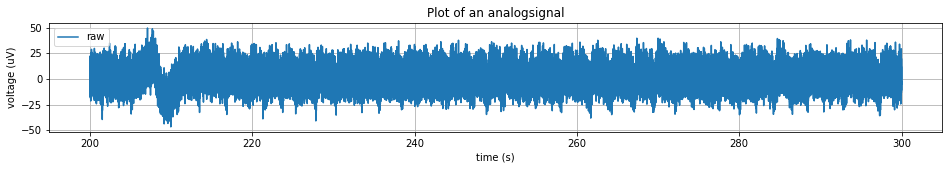

In [6]:
ia=int(200/analog.sampling_period)
ib=int(300/analog.sampling_period)


fig, ax = plt.subplots(1,1, figsize=(16,2))

times = analog.times[ia:ib]
line = np.array(analog)[ia:ib,3]

ax.plot(times,line, c='tab:blue', alpha=1, label='raw')
ax.set(title=f"Plot of an analogsignal",
       xlabel="time (s)",
       ylabel="voltage (uV)")
ax.grid()
ax.legend()

plt.show()

#### Moving average and Butterworth filters on raw signal

In [42]:
from scipy.signal import butter, lfilter, freqz

In [364]:
i=int(30/analog.sampling_period)

fig, ax = plt.subplots(1,1, figsize=(16,4))

times = analog.times[ia:ib]
line = np.array(analog)[ia:ib,8]

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

filt = butter_lowpass_filter(line,50, analog.sampling_rate)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

avg = moving_average(line,400)

ax.plot(analog.times[ia:ib],line, c='b', alpha=0.6, label='raw')
ax.plot(analog.times[ia:ib],filt, c='tab:red', alpha=0.8,lw=2.5, label='lp filter (butter 10Hz)')
ax.plot(analog.times[ia:ib],avg, c='tab:green', alpha=0.8,lw=2.5, label='moving average (300p)')

ax.set(title=f"Plot of an analogsignal (raw and processed)",
       xlabel="time (s)",
       ylabel="voltage (us)")

ax.grid()
ax.legend()

plt.show()

NameError: name 'analog' is not defined

#### Plot of many analog signals

/home/jc/miniconda3/envs/comp/lib/python3.6/site-packages/ipykernel-5.4.3-py3.6.egg/ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


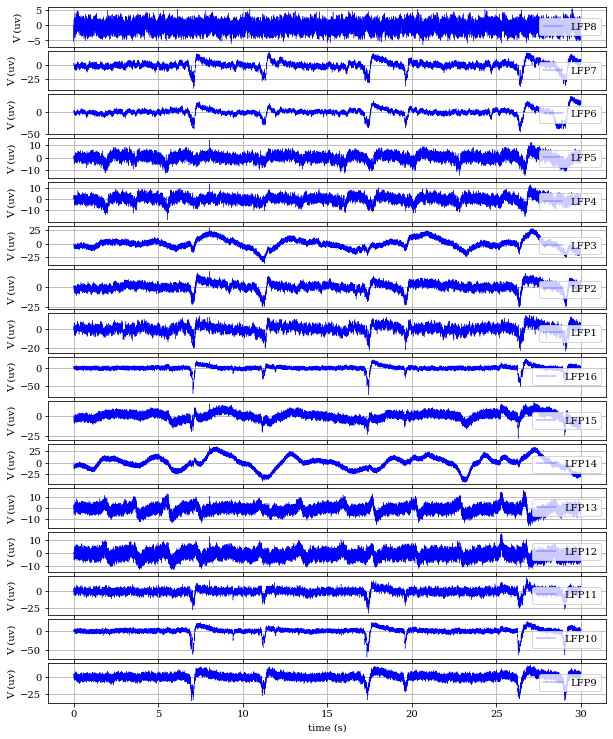

In [28]:
i=int(30/analog.sampling_period)

times = analog.times[:i]
n_lines = analog.shape[1]

fig, ax = plt.subplots(n_lines,1, figsize=(10,n_lines*.8),sharex=True,gridspec_kw={'hspace':0.1 })

name = analog.name[16:-2]
signal_names = name.split(',')

for p in range(n_lines):
    line = np.array(analog)[:i,p]
    filt = butter_lowpass_filter(line,100, analog.sampling_rate)
    ax[p].plot(analog.times[:i], filt, c='b', alpha=1, label=signal_names[p],lw=0.4)
    ax[p].grid()
    ax[p].set(ylabel=f"V (uv)")
    ax[p].legend(loc='right')

ax[p].set( xlabel="time (s)")

#fig.suptitle(analog.name)
#fig.subplots_adjust(top=0.96)

fig.tight_layout()
fig.savefig('./full_recording.pdf', dpi=300)

#### Visualization of the events

In [14]:
analog.sampling_period

array(0.0001008) * 1/Hz

[Text(0.5, 0, 'time (s)')]

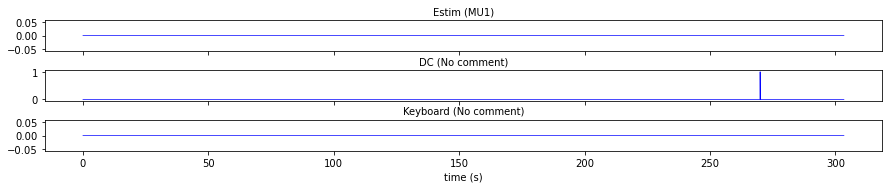

In [13]:
n_events = len(segments.events)
fig, ax = plt.subplots(n_events,1,figsize=(15,n_events*0.8), sharex=True, gridspec_kw={'hspace':0.65 })

times = analog.times[:]

for a,e in zip(ax, segments.events):
    
    title = f"{e.name} ({e.annotations['comment']})"
    
    eve = np.zeros(times.shape[0])
    e_times = np.array(e)
    eve[np.rint(e_times*1/analog.sampling_period).astype(int)] += 1   # Multiply by quotient of d/n_samples
    
    a.plot(times, eve ,label=title, c='b', lw=0.7)
    a.set_title(title, size=10)
    
a.set(xlabel="time (s)")


#### Plot of analog signals and events

In [ ]:
# TBC

#### Spike frequency in analog signals (threshold and fourier)

In [ ]:
# TBC

#### Spike waveform visualization

In [ ]:
# TBC

#### Spike waveform classification

In [ ]:
# TBC

# DATA PROCESSING

Processing of the LFP recording to get down time, up time and frequency

### Data pre-processing

Since my computer has litle memory, it can't fit whole recording in memory. In this first section I read the files and export them channel by channel to numpy binaries.

In [9]:
# This first section creates full list of files
# 1- get list of folders
# 2- get list of files inside every folder. only files that end with .smr

from os import walk

folders = []
files = []
for (dirpath, dirnames, filenames) in walk("./"):
    folders.extend(dirnames)
    break

for fold in folders[1:]:
    for (dirpath, dirnames, filenames) in walk("./"+fold):
        for fn in filenames:
            if fn[-4:] == ".smr": files.append("./"+fold+"/"+fn)
        break


In [365]:
# second section reads every individual file and exports it to its own folder
# naming nomenclature is recordingfolder/filename/filename_channelname.npy

import os

def read_file(file):
    reader = neo.io.Spike2IO(filename=file)
    # reader reads blocks which contain segments which contain signals/trains/groups/etc.
    # in our case a file contains a single block, segment and signal but with x channels 
    grab = reader.read(lazy=False)[0]
    segments = grab.segments[0]
    analog = segments.analogsignals[0]

    times = analog.times[:i]
    n_lines = analog.shape[1]

    name = analog.name[16:-2]
    signal_names = name.split(',')

    folder = file.split('/')[2][:-4]
    dirName = file[:-4]

    if not os.path.exists(dirName):
        os.makedirs(dirName)

    for p in range(n_lines):
        line = np.array(analog)[:i,p]
        name = signal_names[p]

        path = dirName+"/"+folder+"_"+name+".npy"
        np.save(path,line)

    path = dirName+"/"+folder+"_time.npy"
    np.save(path,times)

In [366]:
# It breaks apart for the last 3 folders
# using try_signal_grouping solves it...

def read_file2(file):
    reader = neo.io.Spike2IO(filename=file,try_signal_grouping=False)
    # reader reads blocks which contain segments which contain signals/trains/groups/etc.
    # in our case a file contains a single block, segment and signal but with x channels 
    grab = reader.read(lazy=False)[0]
    segments = grab.segments[0]
    analog = segments.analogsignals

    n_lines = len(analog)

    #signal_names = name.split(',')

    folder = file.split('/')[2][:-4]
    dirName = file[:-4]

    if not os.path.exists(dirName):
        os.makedirs(dirName)

    for p in range(n_lines):
        line = np.array(analog[p])
        name = analog[p].name
        
        path = dirName+"/"+folder+"_"+name+".npy"
        np.save(path,line)

    path = dirName+"/"+folder+"_time.npy"
    np.save(path,analog[p].times)

In [74]:
for filepath in files[:]:
    read_file2(filepath)
    print("Processed file: " + filepath)

Processed file: ./20210222/Rec01_01_Control.smr
Processed file: ./20210222/Rec02_01_DC3_00.smr


### Read files and process them

In [367]:
# decimate function. by default 6 factor downsample since 9900/6=1650 Hz is all the frequency resolution 
# we need for the mua computation

import math
def decimate(signal, R=6):
    pad_size = math.ceil(float(signal.size)/R)*R - signal.size
    signal_padded = np.append(signal, np.zeros(pad_size)*np.NaN)
    signal_padded.reshape(-1, R)
    
    deci = signal_padded.reshape(-1, R).mean(axis=1)
    return deci

In [368]:
# helper functions

from scipy.signal import butter, lfilter, freqz
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

**Manual execution of the processing**

In [279]:
# reading of files, decimation, and sampling parameters computation

record = "Rec02_DC3_00"
channel = "LFP9"

arr = np.load(f'./20210506_slice1/{record}/{record}_{channel}.npy')
time = np.load(f'./20210506_slice1/{record}/{record}_time.npy')

arr_dec = decimate(arr,R=12)
time_dec = decimate(time,R=12)

sampling_period = time_dec[-2]/time_dec.size
sampling_freq = 1/sampling_period

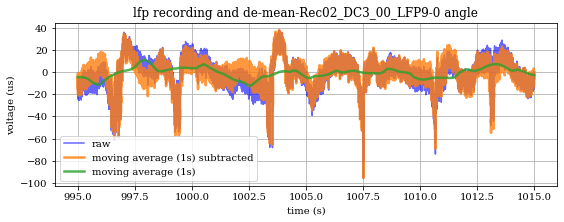

In [280]:
# signal cropping and de-mean (<1 Hz) (and some plots)

ia=int(995/sampling_period)
ib=int(1015/sampling_period)

fig, ax = plt.subplots(1,1, figsize=(9,3))

times = time_dec[ia:ib]
line = arr_dec[ia:ib]

filt = butter_lowpass_filter(line,50, sampling_freq)

avg2 = moving_average(line,int(2/sampling_period))
sub = line-avg2

ax.plot(time_dec[ia:ib],line, c='b', alpha=0.6, label='raw')
#ax.plot(time_dec[ia:ib],filt, c='tab:red', alpha=0.8,lw=2.5, label='lp filter (butter 10Hz)')
ax.plot(time_dec[ia:ib],sub, c='tab:orange', alpha=0.8,lw=2.5, label='moving average (1s) subtracted')
ax.plot(time_dec[ia:ib],avg2, c='tab:green', alpha=0.8,lw=2.5, label='moving average (1s)')

ax.grid()
ax.legend()
ax.set(title=f"lfp recording and de-mean-{record}_{channel}-0 angle",
       xlabel="time (s)",
       ylabel="voltage (us)")

fig.savefig(f"./{record}_{channel}-0angle-step1.pdf")

### MUA estimation

In [370]:
from numpy.fft import rfft

In [371]:
sampling_freq

826.7206601432439

In [ ]:
def get_i_fft(yf, f):
    return int(yf.size*f/(sampling_freq/2))

def compute_power(signal):
    yf = np.abs(rfft(signal))
    yf = yf
    sq = yf*yf
  
    i200, i1500 = get_i_fft(yf, 200), get_i_fft(yf, 1500)
    sq_sum = np.sum(sq[i200:i1500])/(i1500-i200)
    return sq_sum

def compute_mua(signal,time_bin=5*1e-3):
    gen = []
    fft_period = 20*1e-3/sampling_period
    i = 0
    while True:
        ix, iy = int(fft_period*i), int(fft_period*(i+1))
        if ix<len(sub):
            power = compute_power(sub[ix:iy])
            gen.append(power)
            i+=1
        else:
            return gen

In [372]:
from collections import Counter

thr = 4000
def count_peaks(signal, thr_val=thr, ones=250):
    # 1.moving average
    signal = signal
    signal = np.convolve(signal, np.ones(ones))/ones
    # 2.threshold the signal
    thr = signal>thr_val
    # 3.count ascending jumps
    values = thr.astype('int')
    # 3.1 Computes the crossing 1: ascendent -1: descendent
    difference = values[1:]-values[:-1]
    # 3.2 Count the number of 1 (ascendent crossings)
    peaks = Counter(difference)[1]
    return values, peaks

In [ ]:
from collections import Counter
from numpy.fft import rfft
import math

# SIGNAL PROCESSING METHODS
# Methods to compute the mua and moving variance

def decimate(signal, R=6):
    # By default 6 factor downsample since 9900/6=1650 Hz is all the frequency resolution 
    # we need for the mua computation
    pad_size = math.ceil(float(signal.size)/R)*R - signal.size
    signal_padded = np.append(signal, np.zeros(pad_size)*np.NaN)
    signal_padded.reshape(-1, R)
    
    deci = signal_padded.reshape(-1, R).mean(axis=1)
    return deci

def get_i_fft(yf, f):
    return int(yf.size*f/(sampling_freq/2))

def compute_power(signal):
    yf = np.abs(rfft(signal))
    yf = yf
    sq = yf*yf
  
    i200, i1500 = get_i_fft(yf, 200), get_i_fft(yf, 1500)
    sq_sum = np.sum(sq[i200:i1500])/(i1500-i200)
    return sq_sum

def compute_mua(signal, sampling_freq, time_bin=20*ms):
    mua = []
    fft_period = time_bin*sampling_freq
    i = 0
    while True:
        ix, iy = int(fft_period*i), int(fft_period*(i+1))
        if ix<len(sub):
            power = compute_power(sub[ix:iy])
            mua.append(power)
            i+=1
        else:
            return mua

def compute_moving_var(line, sampling_freq, window=100*ms):
    ts = pd.Series(line, index=np.linspace(1,line.size,line.size))
    
    samples = int(window*sampling_freq)
    rolling_var = ts.rolling(window=samples).var().values
    rolling_var = rolling_var[~np.isnan(rolling_var)] # This deletes first nan values
    
    return rolling_var

# POST-PROCESSING METHODS
# To compute statistics for further study of the signals. Frequency computed as #peaks/time.
# The same methods are used to analyze the computer simulations of the model.

def count_peaks(signal, thr_val=3000, ones=250):
    # 1.moving average
    signal = signal
    signal = np.convolve(signal, np.ones(ones))/ones
    # 2.threshold the signal
    thr = signal>thr_val
    # 3.count ascending jumps
    thr_array = thr.astype('int')
    # 3.1 Computes the crossing 1: ascendent -1: descendent
    difference = thr_array[1:]-thr_array[:-1]
    # 3.2 Count the number of 1 (ascendent crossings)
    peaks = Counter(difference)[1]
    return thr_array, peaks

def periods(thr_array, time):
    difference = thr_array[1:]-thr_array[:-1]
    ups = np.where(difference==1)[0]
    downs = np.where(difference==-1)[0]

    sample = time/thr_array.size
    
    # edge cases
    # if one peak detected down time from down to end
    # if no peaks detected up=0 down=time
    up_periods = (downs-ups)*sample
    down_periods = (ups[1:]-downs[:-1])*sample

    if len(ups)==0:
        up_periods = [0]
        down_periods = [0]
    elif len(ups)==1:
        down_periods = [0]
        
    return np.nanmean(up_periods), np.nanmean(down_periods)

In [261]:
time_bin = 20e-3

In [124]:
mua = np.log(compute_mua(sub))
window = int(80e-3/time_bin)
mua_ma = moving_average(mua,w=window)

In [125]:
m = np.nanmin(mua_ma[40:-40])+0.35

In [126]:
det, peaks = count_peaks(mua_ma[:]-m, thr_val=0.3, ones=30)        

In [195]:
line.shape

(66137,)

In [197]:
import pandas as pd

In [360]:
100*sampling_period

0.1209598414810067

In [213]:
25e-3/sampling_period

82.67198695365664

In [351]:
det, peaks = count_peaks(rolling_var[:]-5, thr_val=4, ones=150)        

In [377]:
np.linspace(1,10)

array([ 1.        ,  1.18367347,  1.36734694,  1.55102041,  1.73469388,
        1.91836735,  2.10204082,  2.28571429,  2.46938776,  2.65306122,
        2.83673469,  3.02040816,  3.20408163,  3.3877551 ,  3.57142857,
        3.75510204,  3.93877551,  4.12244898,  4.30612245,  4.48979592,
        4.67346939,  4.85714286,  5.04081633,  5.2244898 ,  5.40816327,
        5.59183673,  5.7755102 ,  5.95918367,  6.14285714,  6.32653061,
        6.51020408,  6.69387755,  6.87755102,  7.06122449,  7.24489796,
        7.42857143,  7.6122449 ,  7.79591837,  7.97959184,  8.16326531,
        8.34693878,  8.53061224,  8.71428571,  8.89795918,  9.08163265,
        9.26530612,  9.44897959,  9.63265306,  9.81632653, 10.        ])

In [ ]:
def moving_var(line, sampling_freq, window=100*ms):
    ts = pd.Series(line, index=np.linspace(1,line.size,line.size))
    
    samples = int(window*sampling_freq)
    rolling_var = ts.rolling(window=samples).var().values
    rolling_var = rolling_var[~np.isnan(rolling_var)] # This deletes first nan values
    
    return rolling_var

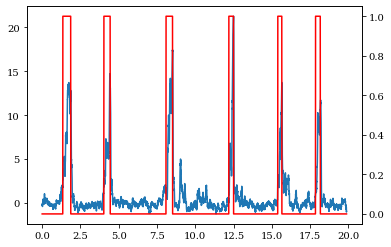

In [352]:
times = time_dec[ia:ib]

ts = pd.Series(line, index=times)

rolling_var = ts.rolling(window=100).var().values
rolling_var = rolling_var[~np.isnan(rolling_var)]
plt.plot(times[:-99]-995,rolling_var[:]-5, alpha=1)
ax2 = plt.twinx()
ax2.plot(times[:-99]-995, det[149:],c="r")
#plt.plot(moving_average(rolling_var,w=50),lw=2.)
#plt.plot(butter_lowpass_filter(rolling_var,20, sampling_freq))


In [ ]:
time

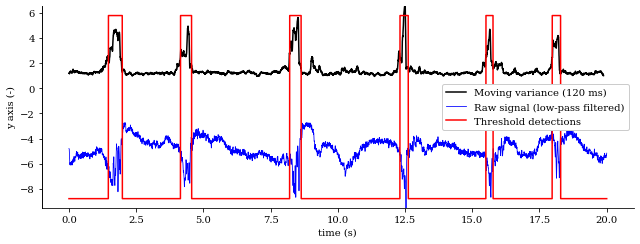

In [361]:

fig, ax = plt.subplots(1,1, figsize=(9,3.5))

#ax.plot(times[10:], (mua)[10:], label="MUA")
times = time_dec[ia:ib]
l1 = plt.plot(times[:-99]-995,rolling_var[:]*0.25, alpha=1,label="Moving variance (120 ms)", c="black")[0]
#l1 = ax.plot(times[10:2000], (mua_ma)[10:2000]-m, label="MUA", c="black")[0]
#line
filt = butter_lowpass_filter(line,100, sampling_freq)
filt = butter_lowpass_filter(filt,40, sampling_freq)

times = np.arange(len(mua))*time_bin

l2 = ax.plot(time_dec[ia:ib]-995, (filt)*0.07-4.8, label="Raw signal (low-pass filtered)", c="b", lw=0.8)[0]
ax2 = ax.twinx()
l3 = ax2.plot(time_dec[ia+0:ib]-995, det[50:],c='r',alpha=1.0, label="Threshold detections", lw=1.5)[0]

#ax.grid()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)


ax.set(xlabel="time (s)",
       ylabel="y axis (-)",
       ylim=[-9.5,6.5])

lines = [l1,l2,l3]

ax2.legend(lines, [l.get_label() for l in lines],facecolor='white', framealpha=1)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.spines['bottom'].set_visible(False)


ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)
#ax.xaxis.set_visible(False)

fig.tight_layout()
fig.savefig(f"./simple_processing.pdf")

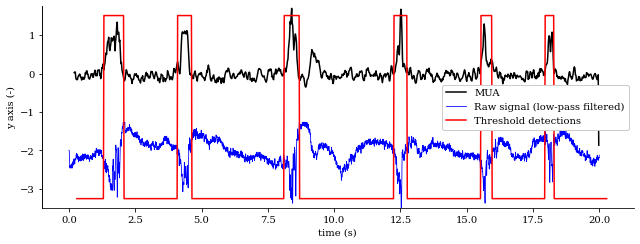

In [293]:
times = np.arange(len(mua))*time_bin

fig, ax = plt.subplots(1,1, figsize=(9,3.5))

#ax.plot(times[10:], (mua)[10:], label="MUA")
l1 = ax.plot(times[10:2000], (mua_ma)[10:2000]-m, label="MUA", c="black")[0]
line
filt = butter_lowpass_filter(line,100, sampling_freq)
filt = butter_lowpass_filter(filt,40, sampling_freq)

l2 = ax.plot(time_dec[ia:ib]-995, (filt)*0.025-2, label="Raw signal (low-pass filtered)", c="b", lw=0.8)[0]
ax2 = ax.twinx()
l3 = ax2.plot(times[0:]+0.3, det[29:],c='r',alpha=1.0, label="Threshold detections", lw=1.5)[0]

#ax.grid()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)


ax.set(xlabel="time (s)",
       ylabel="y axis (-)",
       ylim=[-3.5,1.75])

lines = [l1,l2,l3]

ax2.legend(lines, [l.get_label() for l in lines],facecolor='white', framealpha=1)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.spines['bottom'].set_visible(False)


ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)
#ax.xaxis.set_visible(False)

fig.tight_layout()
fig.savefig(f"./mua_processing.pdf")

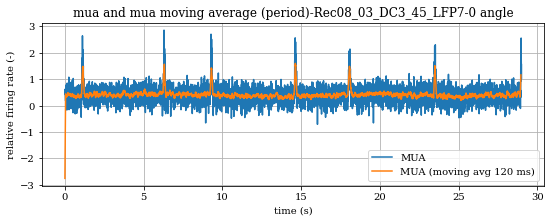

In [49]:
times = np.arange(len(mua))*time_bin

fig, ax = plt.subplots(1,1, figsize=(9,3))

ax.plot(times[:], (mua)[:]-6, label="MUA")
ax.plot(times[:], (mua_ma)[:]-6, label="MUA (moving avg 120 ms)")
#ax2 = ax.twinx()
#ax2.plot(times[:7000], thr[:7000],c='r')

ax.grid()
ax.legend(loc=4)

ax.set(title=f"mua and mua moving average (period)-{record}_{channel}-0 angle",
       xlabel="time (s)",
       ylabel="relative firing rate (-)")

fig.savefig(f"./{record}_{channel}-0angle-step2.pdf")

#### Signal processing 2

In [ ]:
def computeMoving(Signal, WindowSize, StepSize, type_moving):
    """
    Computes moving filter along signal, downsampling. 
    type_moving: can onlye be 'variance' or 'average'
    """
    # number of samples
    SampleNum = int(np.floor((len(Signal['value'])-WindowSize)/StepSize) + 1)
    # time interval
    dt = np.mean(np.diff(Signal['time']))
    # downsample time
    time = np.arange(0,SampleNum)*dt*StepSize+np.mean(Signal['time'][0:WindowSize])
    # matrix
    data = np.zeros((WindowSize,SampleNum))
    # fill it
    data = [Signal['value'][np.arange(k,len(Signal['value'])-WindowSize+k,StepSize)] for k in range(WindowSize)]
    if type_moving == 'average':
        MA = np.mean(data, axis = 0)
        return time, MA
    elif type_moving == 'variance':
        MV = np.std(data, axis = 0, ddof = 1)**2
        return time, MV
    else: 
        raise ValueError('type_moving can only either be average or variance')  

In [ ]:
# compute WinSize
winSize = int(np.round(0.025*RawSig_noArt['Fs']))
t, SigVar = computeMoving(RawSig_noArt, winSize, int(0.5*winSize), type_moving='variance')
SigMean = np.convolve(SigVar, np.ones(winSize)/winSize, mode='same')
SigMean = {'value': SigMean, 'time': t}
SigVar = {'value': SigVar, 'time': t}

thr = 450
# check which threshold to use
fig, ax = plt.subplots(figsize=(16,8), sharex=True)
ax.plot(SigMean['time'], SigVar['value'], c='red')
ax.plot(SigMean['time'], SigMean['value'], c='k')

ax.axhline(thr, c='g')

In [ ]:
MinDuration = [0.5, 0.01] # down, up
UD = compute_UD(SigVar, thr, MinDuration)
fig, ax = plt.subplots(figsize=(16,8), sharex=True)
ax.plot(RawSig_noArt['time'], RawSig_noArt['value'], c='k')
ax.plot(SigMean['time'], SigVar['value'], c='red')
#ax.plot(SigMean['time'], SigMean['value'], c='k')
ax.plot(UD['time'], -500+UD['value']*1000, c='blue')

#### Threshold detection

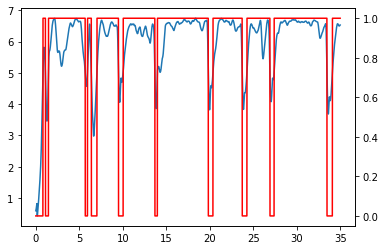

In [522]:
from collections import Counter

# 1.moving average
sol = mua_ma-m
sol = np.convolve(sol, np.ones(50), 'same')/50
# 2.threshold the signal
thr = sol>5
# 3.count ascending jumps
values = thr.astype('int')
# 3.1 Computes the crossing 1: ascendent -1: descendent
difference = values[1:]-values[:-1]
# 3.2 Count the number of 1 (ascendent crossings)
peaks = Counter(difference)[1]

plt.plot(times[:7000], sol[:7000])
plt.twinx()
plt.plot(times[:7000], thr[:7000],c='r')

#### FR histogram

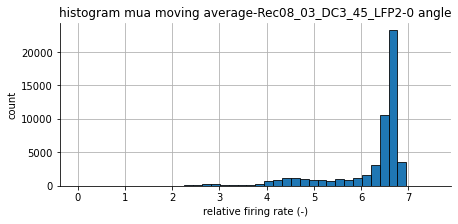

In [524]:
fig, ax = plt.subplots(1,1, figsize=(7,3))

ax.hist(mua_ma-m, bins=40, edgecolor='black', label="Inhibitory population", lw=0.8, alpha=1.0,zorder=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(zorder=0)
ax.set(title=f"histogram mua moving average-{record}_{channel}-0 angle",
       xlabel="relative firing rate (-)",
       ylabel="count")

fig.savefig(f"./{record}_{channel}-0angle-hist.pdf")